# Global Sensitivity Analysis

This section provides an implementation for global sensitivity analysis using the Sobol' method. The Sobol' method is implemented using `SALib`, a Python library built specifically for performing sensitivity analysis. The method is demonstrated on the [Welded Beam Function](https://smt.readthedocs.io/en/latest/_src_docs/problems/weldedbeam.html) and [Water Flow Function](https://smt.readthedocs.io/en/latest/_src_docs/problems/waterflow.html) that are available in the benchmarking problems section of `smt`. The first-order and total Sobol' indices are found using the true function and a Kriging model of the true function.

> __*NOTE*__: `SALib` will have to be installed using `pip install SALib` in your Conda environment before running the code in this section.


## 1. Welded Beam Function

The three-dimensional welded beam function can be represented as:

$$
    \begin{gathered}
        f(\textbf{x}) = \sqrt{\frac{\tau'+\tau''^2+l\tau'\tau''}{\sqrt{0.25(l^2+(h+t)^2)}}} \\
        \textrm{where} \quad  \tau' = \frac{6000}{\sqrt{2}hl}, \tau'' = \frac{6000(14+0.5l)\sqrt{0.25(l^2+(h+t)^2)}}{2[0.707hl(\frac{l^2}{12}+0.25(h+t)^2)]}, \quad \textrm{for} \quad h \in [0.125,1.0], \quad l,t \in [5,10]  \\
    \end{gathered}
$$

The block of code below imports the required packages and defines the Welded Beam Function given in `smt`.

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG
from smt.problems import WaterFlow, WeldedBeam
from SALib.sample import sobol, latin
from SALib.analyze import sobol as SOBOL

# Defining welded beam function problem
ndim = 3
weldedbeam = WeldedBeam(ndim=ndim)

The next block of code defines the sensitivity analysis problem for `SALib`. The problem is defined as a dictionary with the number of variables, names and bounds of the variables. 

In [14]:
# Defining sensitivity analysis problem
xlimits = np.array([[0.125, 1.0], [5.0, 10.0], [5.0, 10.0]])
problem = {
    'num_vars': ndim,
    'names': ['$h$', '$l$', '$t$'],
    'bounds': xlimits
}

In the next block of code, Sobol' sequences are used to create a set of samples for performing Monte Carlo simulations to approximate the relevant integrals for calculating the Sobol' indices. Essentially, the block of code uses functionality in `SALib` to generate the samples using Sobol' sequences and calculate the corresponding function values using the true function. Refer to the lecture notes for further details.

In [15]:
param_values = sobol.sample(problem, 1024)
Y = weldedbeam(param_values)
Y = Y.reshape(-1)

Now, the Sobol' indices can be calculated using the samples and function values generated in the previous code block. Both the first order ($S_1$) and total indices ($S_T$) are calculated. 

In [16]:
Si = SOBOL.analyze(problem, Y)

print("First-order indices:", Si['S1'])
print("\nTotal indices:", Si['ST'])

First-order indices: [0.01028963 0.95648679 0.02772503]

Total indices: [0.01486678 0.96411039 0.02904756]


Next, the code blocks will plot graphs to visualize the Sobol' indices for the different variables of the welded beam function.

(0.0, 1.0)

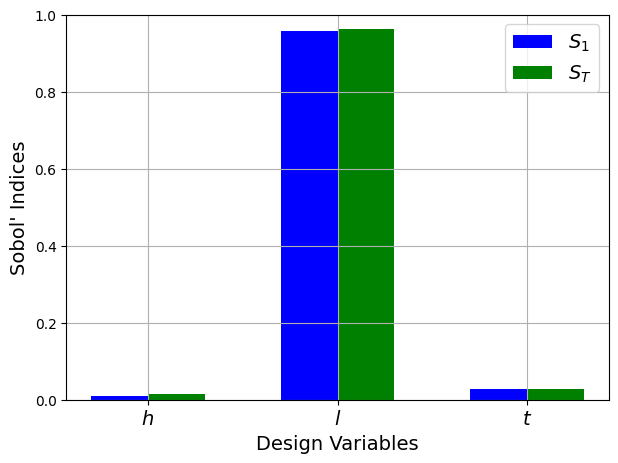

In [17]:
# Plotting first order indices
vars = problem['names']
s1_values = Si['S1']
st_values = Si['ST']
r = np.arange(len(s1_values))
width = 0.3
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(r, s1_values, color ='blue', width = width, label = "$S_1$")
ax.bar(r+width, st_values, color ='green', width = width, label = "$S_T$")
ax.set_xlabel("Design Variables", fontsize = 14)
ax.set_ylabel("Sobol' Indices", fontsize = 14)
ax.set_xticks(r + width/2, vars, fontsize = 14) 
ax.legend(fontsize = 14)
ax.grid()
ax.set_ylim([0.0, 1.0])

From the values of the Sobol' indices, it is clear that the welded beam function is highly sensitive to the $l$ variable and far less sensitive to the other variables. Additionally, the values of the total indices are similar to the first-order indices which means that there are few interaction effects between the design variables of this function.  

In the next few code blocks, the use of surrogates to perform sensitivity analysis is demonstrated. A Kriging model is created of the Welded Beam function using various number of samples and the Monte Carlo simulations needed for calculating the Sobol' indices are performed using the Kriging model instead of the true function. The idea is to reduce the computational cost of calculating the Sobol' indices. The Monte Carlo simulations require 1000s of evaluations of the true function which can be a high-fidelity physics simulation that is expensive to evaluate. Using a surrogate in place of the high-fidelity analysis will greatly reduce the computational cost.

Plots are created to visualize the values of the first-order and total Sobol' indices and a comparison is drawn between the indices calculated using the true function and the Kriging model. 


Number of samples: 5
First-order indices: [1.37693877e-05 9.97302890e-01 2.21067196e-03]

Total indices: [1.42401518e-05 9.97373354e-01 2.53476962e-03]

Number of samples: 10
First-order indices: [0.00646114 0.94960575 0.03035952]

Total indices: [0.01290354 0.96559608 0.03830813]

Number of samples: 15
First-order indices: [0.00822939 0.96370015 0.02501789]

Total indices: [0.01075834 0.96773798 0.02622307]

Number of samples: 20
First-order indices: [0.00998103 0.95926553 0.02575915]

Total indices: [0.01411708 0.9650664  0.02680449]

Number of samples: 25
First-order indices: [0.01029052 0.95532787 0.02881293]

Total indices: [0.01444364 0.9630323  0.03087732]

Number of samples: 30
First-order indices: [0.01032052 0.95940491 0.02493292]

Total indices: [0.01492942 0.96554287 0.02594154]


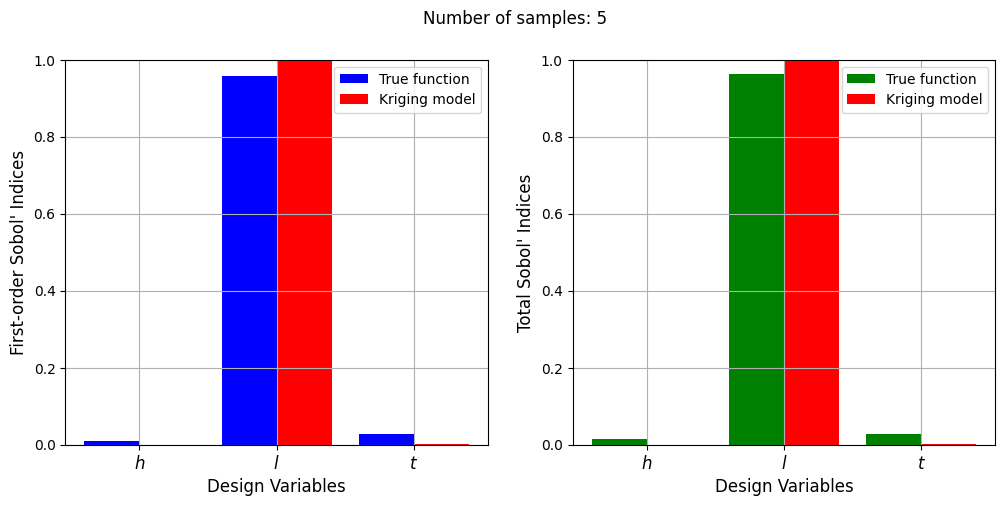

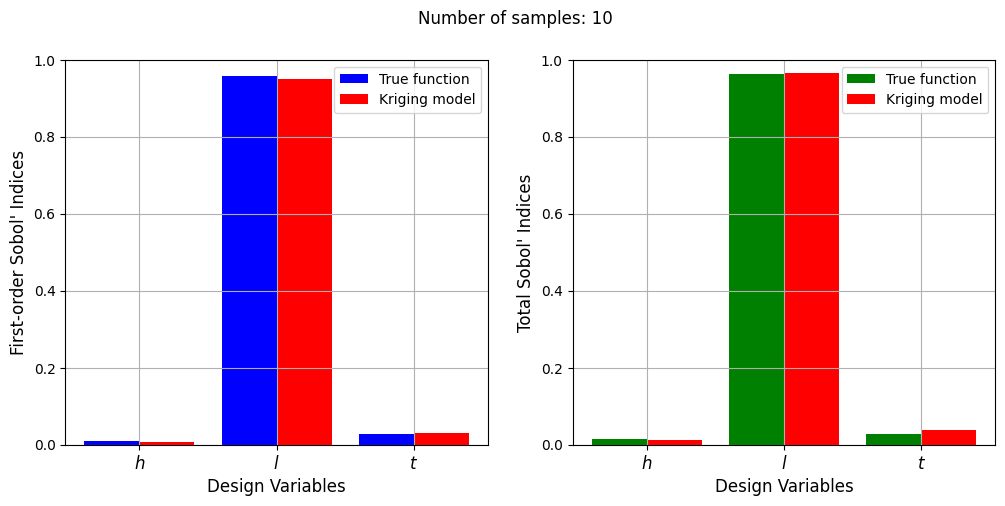

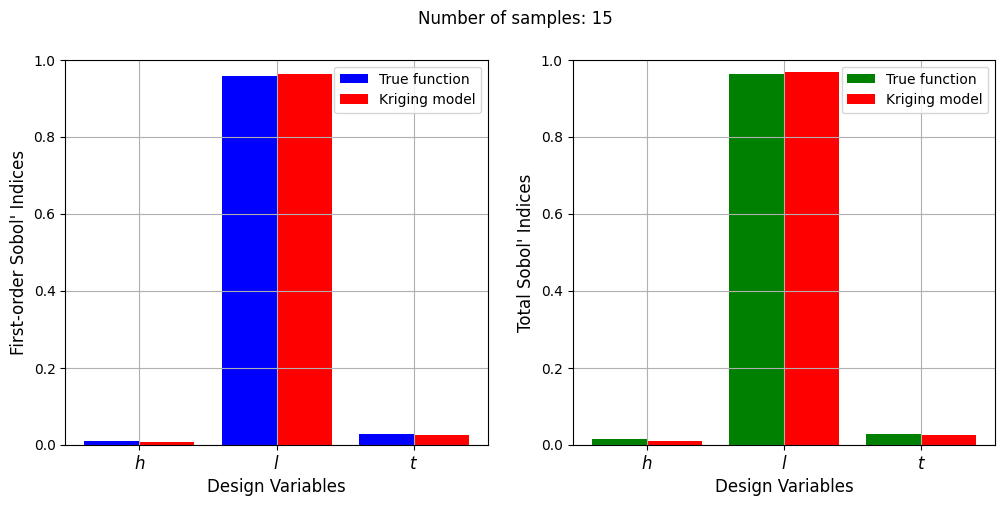

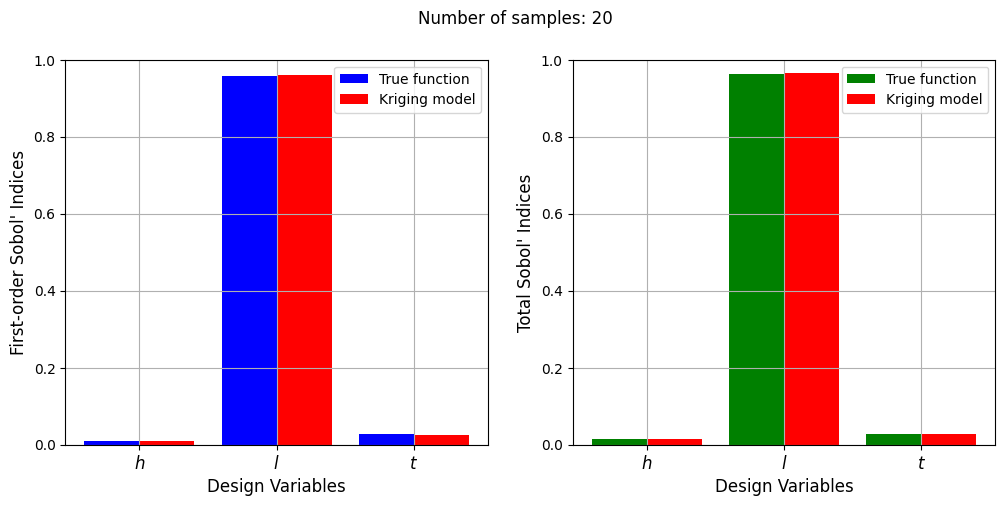

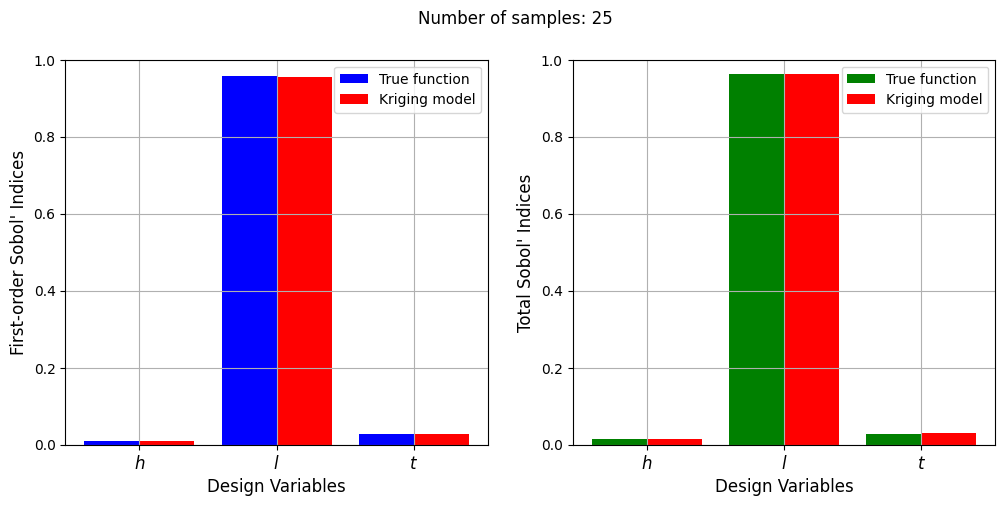

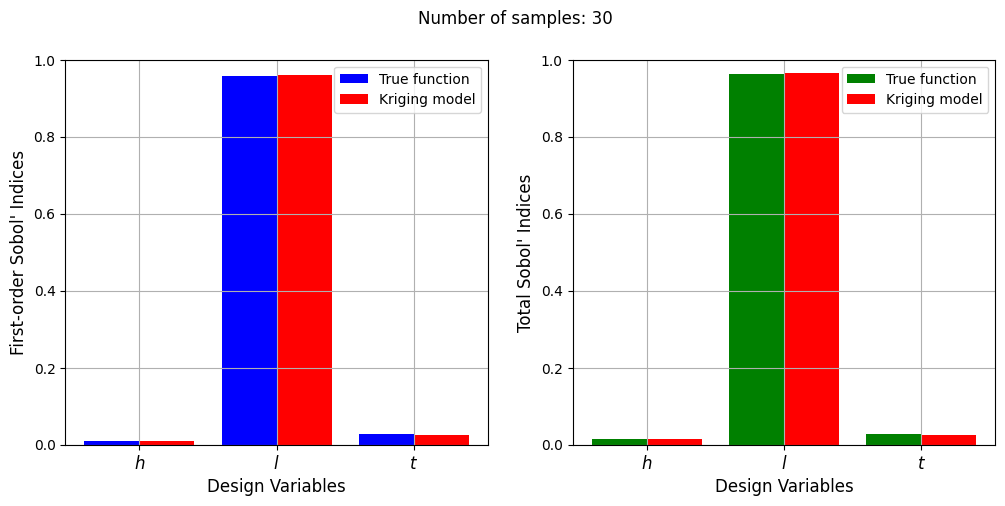

In [18]:
# Defining sample sizes
samples = np.arange(5,35,5)

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    ytrain = weldedbeam(xtrain)

    # Create kriging model
    corr = 'squar_exp'
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()

    # Generate values for Sobol sequence samples using the surrogate
    surrogate_Y = sm.predict_values(param_values)
    surrogate_Y = surrogate_Y.reshape(-1)
    
    Si_surrogate = SOBOL.analyze(problem, surrogate_Y)
    print("\nNumber of samples:", size)
    print("First-order indices:", Si_surrogate['S1'])
    print("\nTotal indices:", Si_surrogate['ST'])
    
    # Plotting first order indices 
    vars = problem['names']
    s1_surrogate = Si_surrogate['S1']
    r = np.arange(len(s1_surrogate))
    width = 0.4
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].bar(r, s1_values, color ='blue', width = width, label = "True function")
    ax[0].bar(r+width, s1_surrogate, color ='red', width = width, label = "Kriging model")
    ax[0].set_xlabel("Design Variables", fontsize = 12)
    ax[0].set_ylabel("First-order Sobol' Indices", fontsize = 12)
    ax[0].set_xticks(r + width/2, vars, fontsize = 12) 
    ax[0].legend()
    ax[0].grid()
    ax[0].set_ylim([0.0, 1.0])

    # Plotting total indices
    st_surrogate = Si_surrogate['ST']
    ax[1].bar(r, st_values, color ='green', width = width, label = "True function")
    ax[1].bar(r+width, st_surrogate, color ='red', width = width, label = "Kriging model")
    ax[1].set_xlabel("Design Variables", fontsize = 12)
    ax[1].set_ylabel("Total Sobol' Indices", fontsize = 12)
    ax[1].set_xticks(r + width/2, vars, fontsize = 12) 
    ax[1].grid()
    ax[1].legend(fontsize = 10)
    ax[1].set_ylim([0.0, 1.0])
    fig.suptitle("Number of samples: {}".format(size))

With a few number of samples, the Kriging model cannot model the Welded Beam function well enough to accurately calculate the Sobol' indices. As the number of samples increases, the Kriging model becomes more accurate and the Sobol' indices calculated using the Kriging model match closely with those calculated using the true function. However, calculating the Sobol' indices using the Kriging model only required 20 - 30 evaluations of the true function which makes it effective in reducing the computational cost of calculating global sensitivities.

## 2. Water Flow Function

The eight-dimensional water flow function can be represented as:

$$
        f(\textbf{x}) = \frac{2\pi T_u (H_u - H_l)}{\textrm{ln}(\frac{r}{r_w})[1 + \frac{2LT_u}{\textrm{ln}(\frac{r}{r_w})r_w^2K_w}+\frac{T_u}{T_l}]} \\
$$

$$   \textrm{where} \quad r_w \in [0.05,0.15], \quad r \in [100, 50000], \quad T_u \in [63070, 115600], \quad H_u \in [990, 1110], \quad T_l \in [63.10,116], \quad H_l \in [700, 820], \quad L \in [1120, 1680], \quad K_w \in [9855, 12045]       \\
$$

The blocks of code below defines the Water Flow Function given in `smt` and calculates the Sobol' indices for the variables in a similar manner as the Welded Beam Function.

In [19]:
# Defining the water flow function
ndim = 8
waterflow = WaterFlow(ndim=ndim)

In [20]:
# Defining sensitivity analysis problem
xlimits = np.array([[0.05, 0.15], [100.0, 50000.0], [63070, 115600], [990, 1110], [63.10, 116], [700, 820], [1120, 1680], [9855, 12045]])
problem = {
    'num_vars': ndim,
    'names': ['$r_w$', '$r$', '$T_u$', '$H_u$', '$T_l$', '$H_l$', '$L$', '$K_w$'],
    'bounds': xlimits
}

Now, the Sobol' indices are calculated using the true function and plots are created to visualize the values of the Sobol' indices.

In [21]:
param_values = sobol.sample(problem, 1024)
Y = waterflow(param_values)
Y = Y.reshape(-1)

In [22]:
Si = SOBOL.analyze(problem, Y)

print("First-order indices:", Si['S1'])
print("\nTotal indices:", Si['ST'])

First-order indices: [ 8.28445308e-01 -4.51840066e-06  8.17747609e-08  4.08135673e-02
 -2.75497538e-06  4.01758270e-02  4.40706102e-02  8.96296218e-03]

Total indices: [8.73379076e-01 2.19954119e-06 1.09106045e-11 5.42752602e-02
 1.06218066e-05 5.43927734e-02 5.23769342e-02 1.30887982e-02]


(0.0, 1.0)

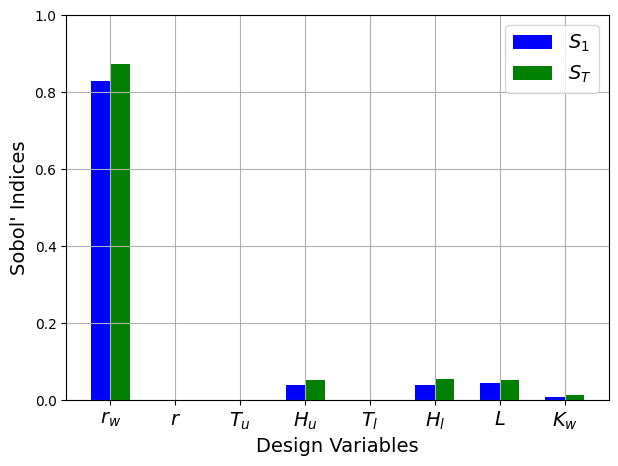

In [23]:
# Plotting first order indices
vars = problem['names']
s1_values = Si['S1']
st_values = Si['ST']
r = np.arange(len(s1_values))
width = 0.3
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(r, s1_values, color ='blue', width = width, label = "$S_1$")
ax.bar(r+width, st_values, color ='green', width = width, label = "$S_T$")
ax.set_xlabel("Design Variables", fontsize = 14)
ax.set_ylabel("Sobol' Indices", fontsize = 14)
ax.set_xticks(r + width/2, vars, fontsize = 14) 
ax.legend(fontsize = 14)
ax.grid()
ax.set_ylim([0.0, 1.0])

From the values of the Sobol' indices, it is clear that the water flow function is highly sensitive to the $r_w$ variable and slightly sensitive to the $H_u$, $H_l$, $L$, and $K_w$ variables. It can also be seen that the total indices are larger than the first-order indices indicating the presence of interaction effects between the variables of this function. 

The next few code block utilize a Kriging model to conduct the sensitivity analysis in a similar manner to the analysis conducted for the welded beam function.


Number of samples: 5
First-order indices: [ 9.09453236e-01  1.01484682e-07  2.84420240e-07  2.41076387e-04
  9.53073619e-06 -2.63986219e-07  3.54414696e-03  1.85055159e-06]

Total indices: [9.88208190e-01 6.47413493e-09 1.25730097e-09 2.62921201e-04
 2.70841802e-06 9.72896068e-09 1.02623799e-01 5.17662453e-07]

Number of samples: 10
First-order indices: [8.76237150e-01 1.70769100e-05 3.57098438e-05 4.40251692e-02
 1.36823386e-04 3.48797078e-02 2.68572720e-02 2.90377951e-04]

Total indices: [8.92715767e-01 1.29002370e-05 1.12347518e-05 5.51917788e-02
 1.15759764e-04 4.37616905e-02 2.76871857e-02 3.09648771e-04]

Number of samples: 15
First-order indices: [8.79510204e-01 6.40388671e-04 3.37737209e-04 3.61289304e-02
 4.88321899e-05 2.75694156e-02 3.64030470e-02 4.72334530e-03]

Total indices: [8.96781883e-01 6.41577284e-04 2.45672874e-04 4.95793460e-02
 4.14065306e-05 2.87018791e-02 3.81492365e-02 5.01060712e-03]

Number of samples: 20
First-order indices: [ 8.18288438e-01  6.42833707e-0

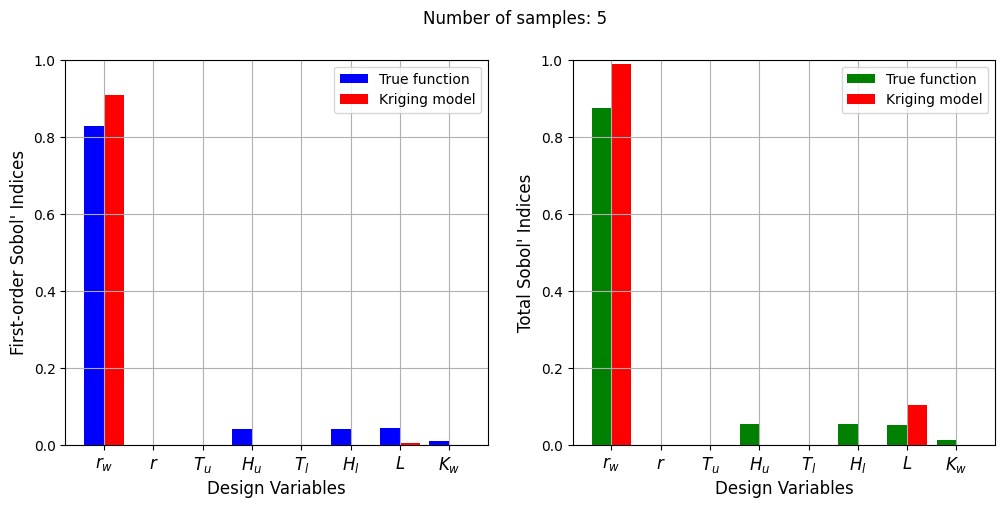

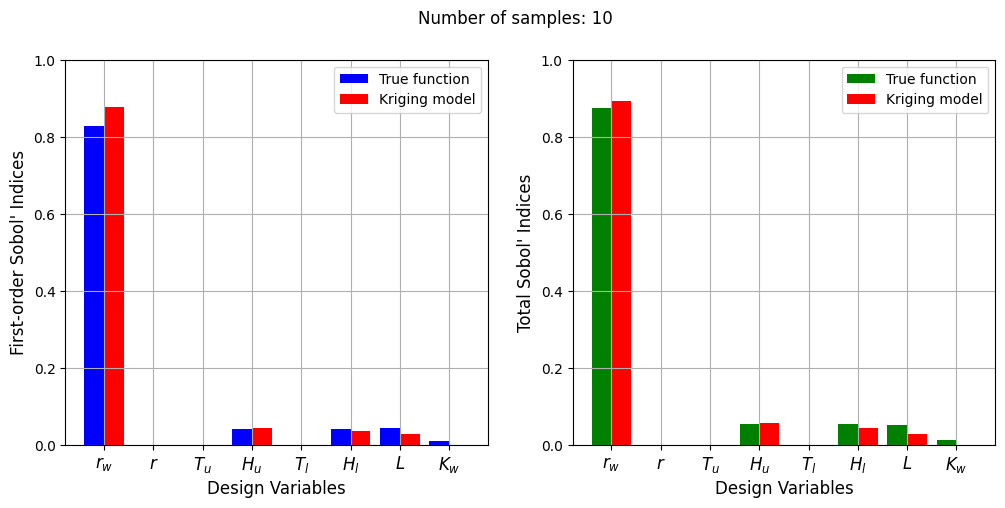

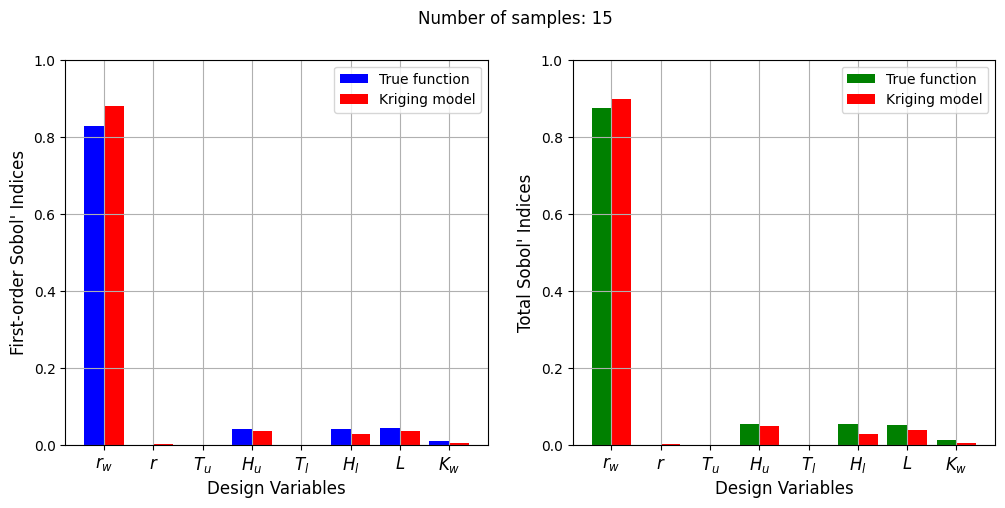

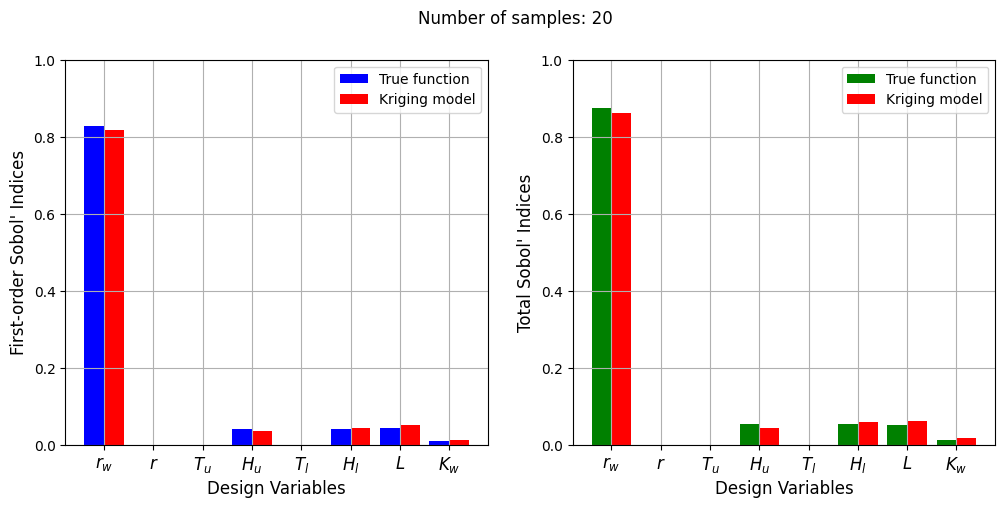

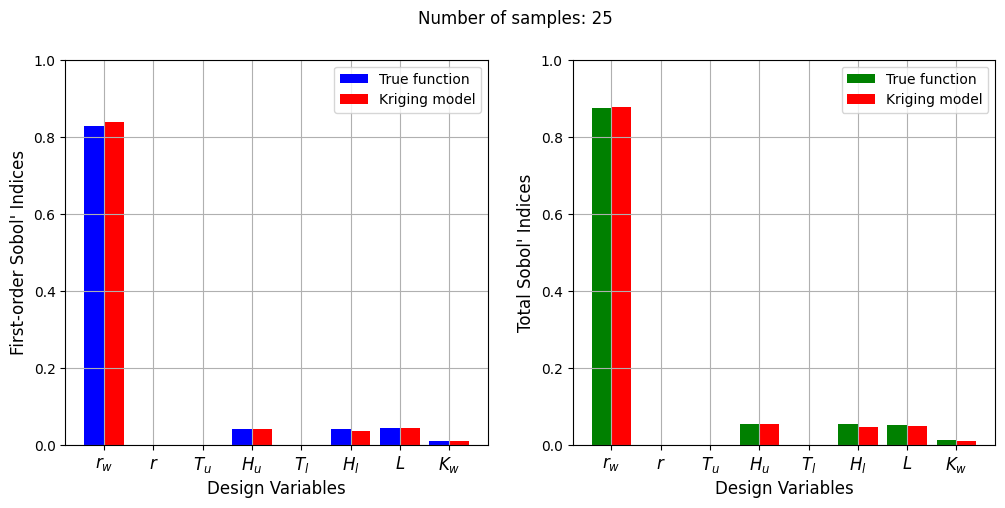

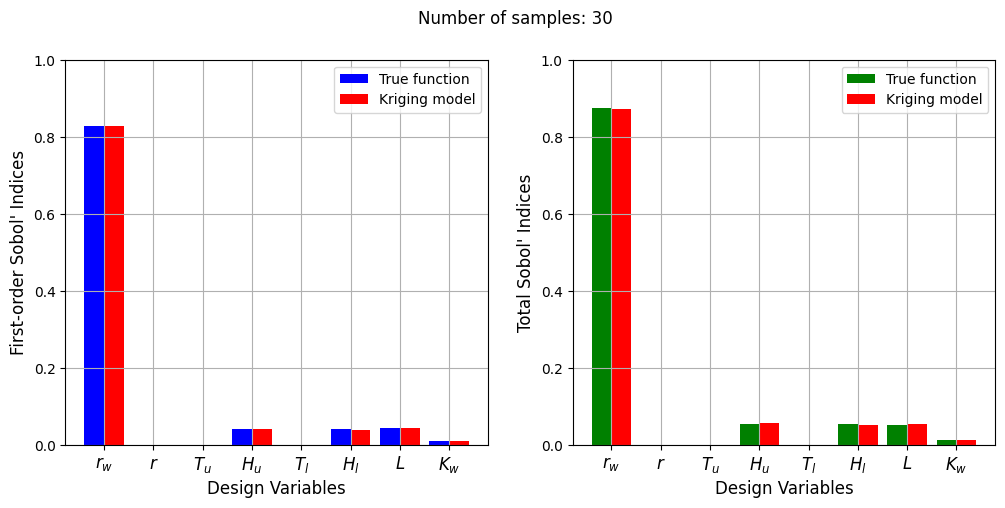

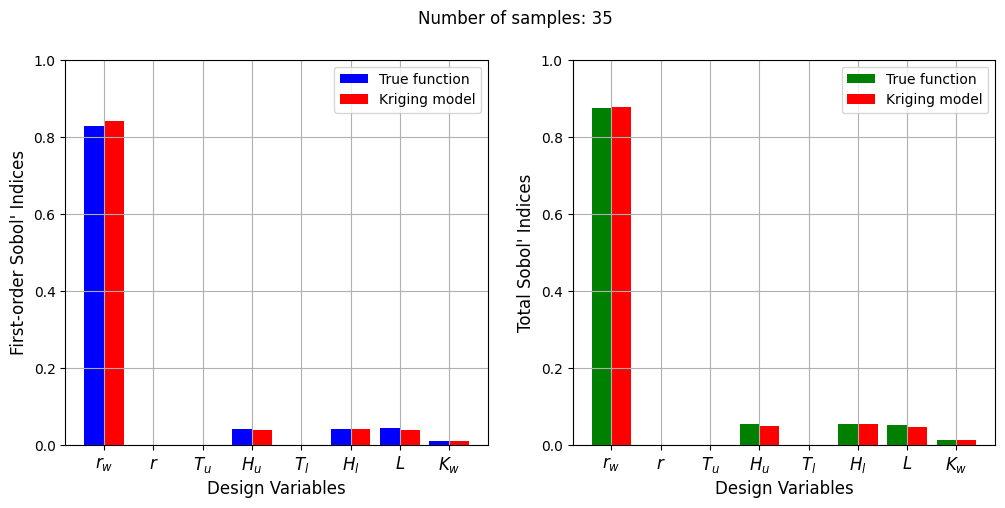

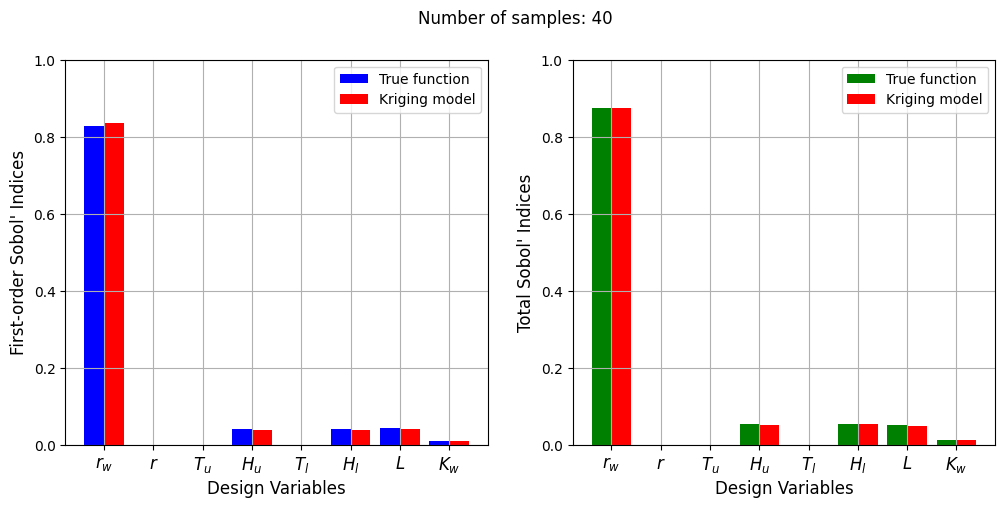

In [24]:
# Defining sample sizes
samples = np.arange(5,45,5)

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    ytrain = waterflow(xtrain)

    # Create kriging model
    corr = 'squar_exp'
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()

    # Generate values for Sobol sequence samples using the surrogate
    surrogate_Y = sm.predict_values(param_values)
    surrogate_Y = surrogate_Y.reshape(-1)
    
    Si_surrogate = SOBOL.analyze(problem, surrogate_Y)
    print("\nNumber of samples:", size)
    print("First-order indices:", Si_surrogate['S1'])
    print("\nTotal indices:", Si_surrogate['ST'])
    
    # Plotting first order indices 
    vars = problem['names']
    s1_surrogate = Si_surrogate['S1']
    r = np.arange(len(s1_surrogate))
    width = 0.4
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].bar(r, s1_values, color ='blue', width = width, label = "True function")
    ax[0].bar(r+width, s1_surrogate, color ='red', width = width, label = "Kriging model")
    ax[0].set_xlabel("Design Variables", fontsize = 12)
    ax[0].set_ylabel("First-order Sobol' Indices", fontsize = 12)
    ax[0].set_xticks(r + width/2, vars, fontsize = 12) 
    ax[0].legend(fontsize = 10)
    ax[0].grid()
    ax[0].set_ylim([0.0, 1.0])

    # Plotting total indices
    st_surrogate = Si_surrogate['ST']
    ax[1].bar(r, st_values, color ='green', width = width, label = "True function")
    ax[1].bar(r+width, st_surrogate, color ='red', width = width, label = "Kriging model")
    ax[1].set_xlabel("Design Variables", fontsize = 12)
    ax[1].set_ylabel("Total Sobol' Indices", fontsize = 12)
    ax[1].set_xticks(r + width/2, vars, fontsize = 12) 
    ax[1].grid()
    ax[1].legend(fontsize = 10)
    ax[1].set_ylim([0.0, 1.0])
    fig.suptitle("Number of samples: {}".format(size))

The Kriging model cannot model the Water Flow function well enough to accurately calculate the Sobol' indices with a few number of samples. As the number of samples increases, the Kriging model becomes more accurate and the Sobol' indices calculated using the Kriging model match closely with those calculated using the true function. In this case, almost 40 samples are required to accurately calculate the Sobol' indices as there are more number of variables in this function and there are more interaction effects to capture. However, the computational cost is still much cheaper than calculating the Sobol' indices using the true function. 